In [ ]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')

# Load dataset
file_path = "/content/train.csv"  # Update path if needed
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)  # Remove links, mentions, hashtags
    text = re.sub(r"[^a-z\s]", "", text)  # Remove special characters and numbers
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization & stopword removal
    return " ".join(tokens)

# Apply text preprocessing
df["Cleaned_Text"] = df["SentimentText"].astype(str).apply(preprocess_text)

# Show sample results
df[["SentimentText", "Cleaned_Text"]].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,SentimentText,Cleaned_Text
0,"@RailMinIndia My PNR is 8348062961, I am in wa...",pnr way water toilet mess everywhere coach ple...
1,@sureshpprabhu @RailMinIndia AC not working in...,ac working prayag lucknow intercity today depa...
2,@RailMinIndia I'm traveling to chennai by trai...,im traveling chennai train coach berth dirtyso...
3,@RailMinIndia irctc is not responding at the t...,irctc responding time tatkal booking
4,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,matter notified concerned official


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=20)  # Extract top 20 keywords
tfidf_matrix = vectorizer.fit_transform(df["Cleaned_Text"])

# Get feature names (keywords)
keywords = vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords)

# Add extracted keywords to the original DataFrame
df["Keywords"] = tfidf_df.apply(lambda row: ", ".join(row[row > 0].index), axis=1)

# Show sample results
df[["Cleaned_Text", "Keywords"]].head()


,Cleaned_Text,Keywords
0,pnr way water toilet mess everywhere coach ple...,"coach, please, pnr, toilet, water"
1,ac working prayag lucknow intercity today depa...,"ac, working"
2,im traveling chennai train coach berth dirtyso...,"coach, train"
3,irctc responding time tatkal booking,"tatkal, time"
4,matter notified concerned official,


In [ ]:
# Define keywords for each complaint category
category_keywords = {
    "Cleanliness Issues": ["clean", "toilet", "dirty", "garbage", "sanitation", "hygiene", "filthy", "smell","litter","washroom","spilled"],
    "Infrastructure Problems": ["track", "bridge", "station", "signal", "platform", "road", "construction", "broken","damage","malfunction","leak","fan","roof","function","non","boards"],
    "Overcrowding": ["crowd", "rush", "full", "standing", "passenger", "congested", "overloaded","comfort","excesss","author","sit","ventilation"],
    "Suspicious Activity": ["suspicious", "terror", "threat", "unattended", "illegal", "danger", "security", "bomb","faulty"],
    "Ticketing Issues": ["ticket", "refund", "cancel", "book", "reservation", "payment", "failure"],
    "Train Delays & Cancellations": ["delay", "late", "cancelled", "schedule", "arrival", "departure", "missed"],
    "Staff Behavior & Service": ["rude", "misbehave", "staff", "conductor", "driver", "unhelpful", "attitude","beggar","reserve"],
    "Catering & Food Quality": ["food", "catering", "unhygienic", "stale", "bad", "water", "meal", "quality","poor","contaminated","expire","overprice","dirty","seller"]
}

# Function to categorize complaints based on keywords
def categorize_complaint(text):
    category_counts = {category: sum(keyword in text for keyword in keywords) for category, keywords in category_keywords.items()}
    return max(category_counts, key=category_counts.get)  # Assign to the category with the highest match

# Apply categorization
df["Category"] = df["Cleaned_Text"].apply(categorize_complaint)

# Show sample results
df[["Cleaned_Text", "Category"]].head()


,Cleaned_Text,Category
0,pnr way water toilet mess everywhere coach ple...,Cleanliness Issues
1,ac working prayag lucknow intercity today depa...,Staff Behavior & Service
2,im traveling chennai train coach berth dirtyso...,Cleanliness Issues
3,irctc responding time tatkal booking,Ticketing Issues
4,matter notified concerned official,Cleanliness Issues


In [ ]:
# Define department mapping
department_mapping = {
    "Cleanliness Issues": "Housekeeping Department",
    "Infrastructure Problems": "Engineering & Maintenance",
    "Overcrowding": "Operations Control",
    "Suspicious Activity": "Security & Vigilance",
    "Ticketing Issues": "Ticketing & Reservations",
    "Train Delays & Cancellations": "Operations & Scheduling",
    "Staff Behavior & Service": "HR & Training",
    "Catering & Food Quality": "Food & Catering Services"
}

# Assign departments based on category
df["Department"] = df["Category"].map(department_mapping)

# Show sample complaints with assigned departments
df[["Cleaned_Text", "Category", "Department"]].head()


,Cleaned_Text,Category,Department
0,pnr way water toilet mess everywhere coach ple...,Cleanliness Issues,Housekeeping Department
1,ac working prayag lucknow intercity today depa...,Staff Behavior & Service,HR & Training
2,im traveling chennai train coach berth dirtyso...,Cleanliness Issues,Housekeeping Department
3,irctc responding time tatkal booking,Ticketing Issues,Ticketing & Reservations
4,matter notified concerned official,Cleanliness Issues,Housekeeping Department


In [ ]:
# Sort entire dataframe by sentiment score in descending order
df_sorted = df.sort_values(by="Sentiment", ascending=False)

# Save as a common CSV file
df_sorted.to_csv("All_Complaints_Sorted.csv", index=False)

print("Saved: All_Complaints_Sorted.csv")

Saved: All_Complaints_Sorted.csv


In [ ]:
!pip install numpy pandas scikit-learn xgboost lightgbm seaborn matplotlib


In [ ]:
########################################################################
# Save separate CSV files for each department sorted by sentiment score
for department in df["Department"].unique():
    df_filtered = df[df["Department"] == department]

    # Sorting in descending order (higher sentiment score first)
    df_filtered = df_filtered.sort_values(by="Sentiment", ascending=False)

    # Creating filename
    filename = f"{department.replace(' ', '_')}.csv"

    # Save CSV file
    df_filtered.to_csv(filename, index=False)

    print(f"Saved: {filename}")

In [ ]:
########################################################################

def predict_category(complaint_text):
    # Preprocess input text
    cleaned_text = preprocess_text(complaint_text)

    # Predict category
    predicted_category = categorize_complaint(cleaned_text)

    # Get the responsible department
    assigned_department = department_mapping[predicted_category]

    return predicted_category, assigned_department


In [ ]:
########################################################################

# Example: User enters a complaint
user_complaint = input("Enter your railway complaint: ")

# Predict category and department
category, department = predict_category(user_complaint)

# Print the result
print(f"\n🚆 Predicted Category: {category}")
print(f"🏢 Assigned Department: {department}")


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import joblib

# Load dataset
df = pd.read_csv("All_Complaints_Sorted.csv")
df.dropna(subset=['Cleaned_Text', 'Department'], inplace=True)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['Processed_Text'] = df['Cleaned_Text'].apply(preprocess_text)

# Encode labels
departments = df['Department'].unique()
department_mapping = {dept: idx for idx, dept in enumerate(departments)}
df['Dept_Label'] = df['Department'].map(department_mapping)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['Processed_Text'], df['Dept_Label'], test_size=0.2, random_state=42)

# Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'Naive Bayes': MultinomialNB()
}

# Train & evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Calculate specificity and NPV for multiclass
    conf_matrix = confusion_matrix(y_test, y_pred)
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Specificity and NPV per class
    specificity = TN/(TN+FP)
    npv = TN/(TN+FN)

    # Average specificity and NPV
    avg_specificity = np.mean(specificity)
    avg_npv = np.mean(npv)

    results[name] = [accuracy, precision, recall, f1, avg_specificity, avg_npv]

# Select best model
best_model_name = max(results, key=lambda k: results[k][0])
best_model = models[best_model_name]
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

# Classify complaints & save to CSV
def classify_and_save():
    df['Predicted_Dept'] = best_model.predict(vectorizer.transform(df['Processed_Text']))
    df['Predicted_Dept'] = df['Predicted_Dept'].map({v: k for k, v in department_mapping.items()})
    for dept in df['Predicted_Dept'].unique():
        df[df['Predicted_Dept'] == dept].to_csv(f'{dept}.csv', index=False)

classify_and_save()

# User input prediction
def predict_department(complaint):
    processed_complaint = preprocess_text(complaint)
    transformed_complaint = vectorizer.transform([processed_complaint])
    predicted_dept = best_model.predict(transformed_complaint)[0]
    return {v: k for k, v in department_mapping.items()}[predicted_dept]

# Sentiment Analysis & Prioritization
def prioritize_complaints():
    df_sorted = df.sort_values(by='Sentiment', ascending=False)
    for dept in df_sorted['Predicted_Dept'].unique():
        df_sorted[df_sorted['Predicted_Dept'] == dept].to_csv(f'{dept}_prioritized.csv', index=False)

prioritize_complaints()

# Example usage
new_complaint = "The train was delayed by 3 hours"
assigned_department = predict_department(new_complaint)
print(f'The complaint is classified under: {assigned_department}')


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

The complaint is classified under: Operations & Scheduling


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from transformers import pipeline

# Load complaints dataset
file_path = "All_Complaints_Sorted.csv"
df = pd.read_csv(file_path)

# Ensure required columns exist
if "Cleaned_Text" not in df.columns or "Department" not in df.columns:
    raise ValueError("Dataset must contain 'Complaint' and 'Department' columns.")

# Encode department labels
label_encoder = LabelEncoder()
df["Department_Label"] = label_encoder.fit_transform(df["Department"])

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["Cleaned_Text"])
y = df["Department_Label"]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Load BERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Function to classify complaint and perform sentiment analysis
def classify_complaint(complaint_text):
    # Predict department
    complaint_vectorized = vectorizer.transform([complaint_text])
    department_label = model.predict(complaint_vectorized)[0]
    department = label_encoder.inverse_transform([department_label])[0]

    # Perform sentiment analysis
    sentiment = sentiment_pipeline(complaint_text)[0]
    sentiment_label = sentiment["label"]
    sentiment_score = sentiment["score"]

    return department, sentiment_label, sentiment_score

# Function to store complaint in respective department CSV
def store_complaint(complaint_text):
    department, sentiment_label, sentiment_score = classify_complaint(complaint_text)
    new_entry = pd.DataFrame([[complaint_text, department, sentiment_label, sentiment_score]],
                             columns=["Cleaned_Text", "Department", "Sentiment", "Score"])

    # Save to respective department CSV
    department_file = f"{department}_complaints.csv"
    try:
        existing_df = pd.read_csv(department_file)
        updated_df = pd.concat([existing_df, new_entry], ignore_index=True)
    except FileNotFoundError:
        updated_df = new_entry

    updated_df.to_csv(department_file, index=False)
    print(f"Complaint stored in {department_file}")

# Take user complaint input
user_complaint = input("Enter your complaint: ")
store_complaint(user_complaint)


ValueError: np.nan is an invalid document, expected byte or unicode string.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7737
Precision: 0.8021
Recall: 0.7737
F1 Score: 0.7399


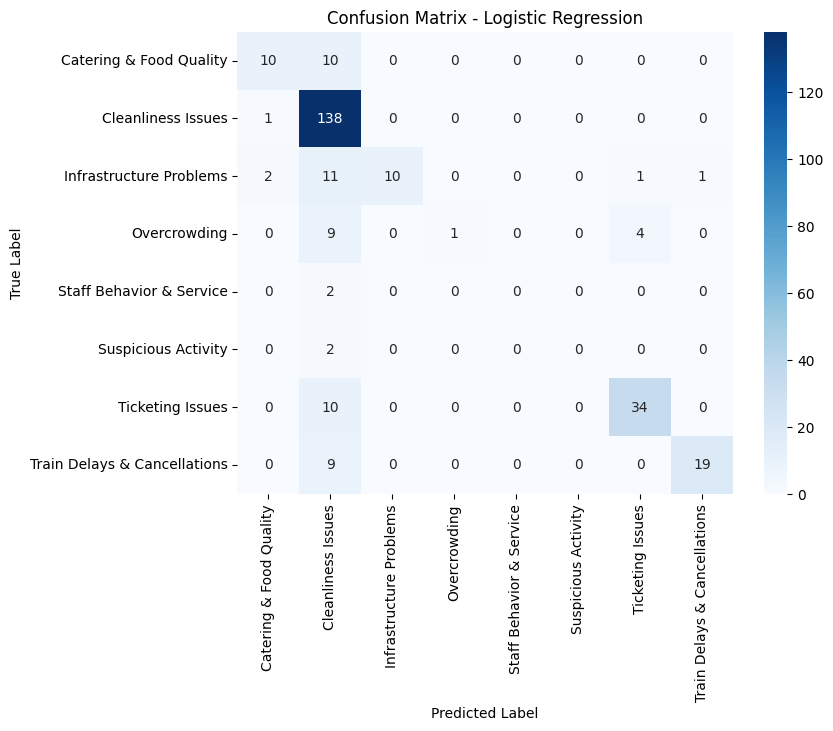

Training Naive Bayes...

Naive Bayes Results:
Accuracy: 0.6971
Precision: 0.7081
Recall: 0.6971
F1 Score: 0.6353


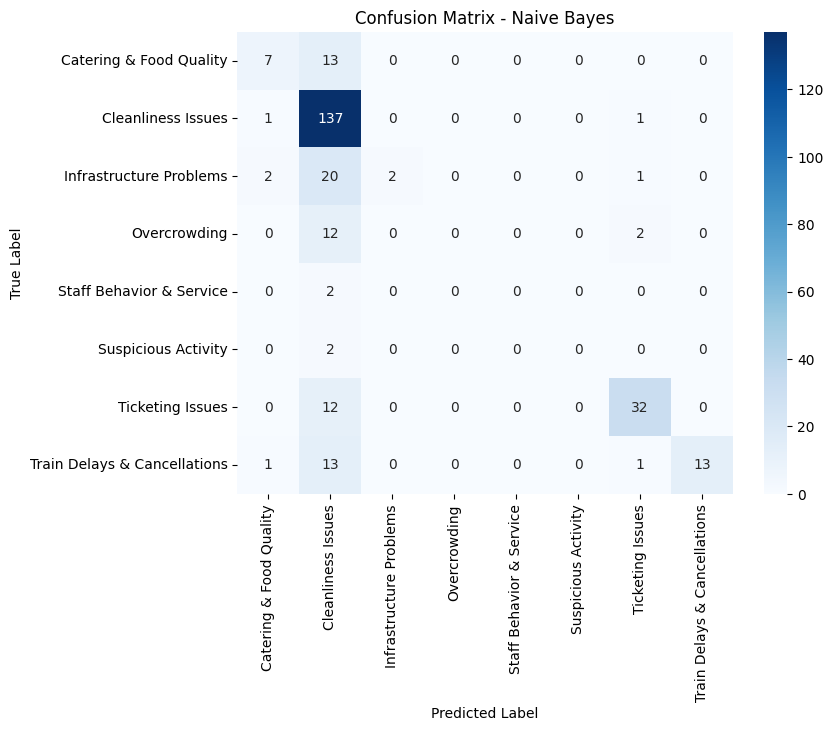

Training SVM...

SVM Results:
Accuracy: 0.7774
Precision: 0.8116
Recall: 0.7774
F1 Score: 0.7441


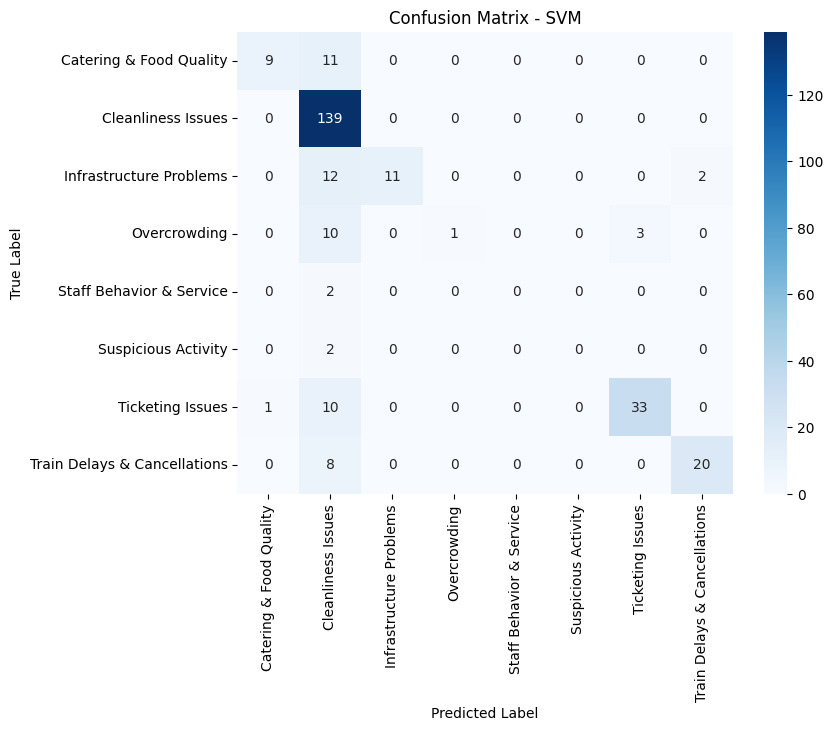

Training KNN...

KNN Results:
Accuracy: 0.5219
Precision: 0.4254
Recall: 0.5219
F1 Score: 0.3713


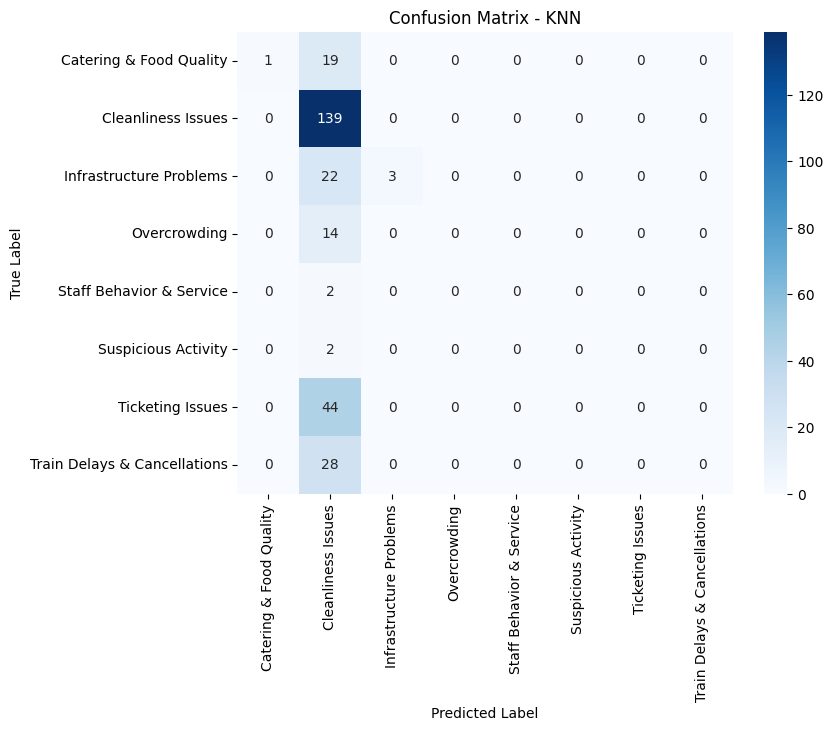

Training Random Forest...

Random Forest Results:
Accuracy: 0.8613
Precision: 0.8569
Recall: 0.8613
F1 Score: 0.8506


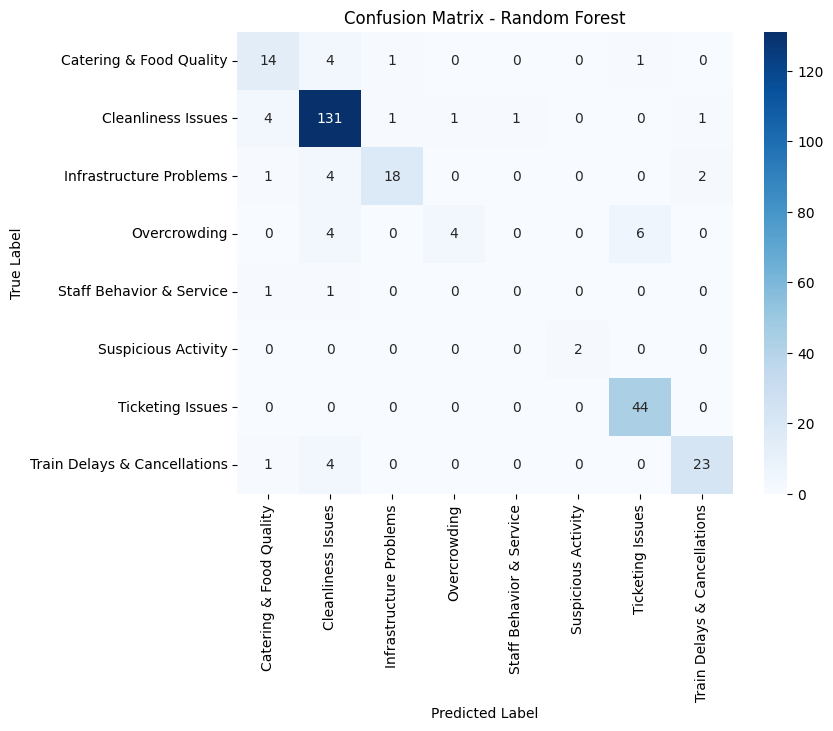

Training Gradient Boosting...

Gradient Boosting Results:
Accuracy: 0.8978
Precision: 0.8987
Recall: 0.8978
F1 Score: 0.8942


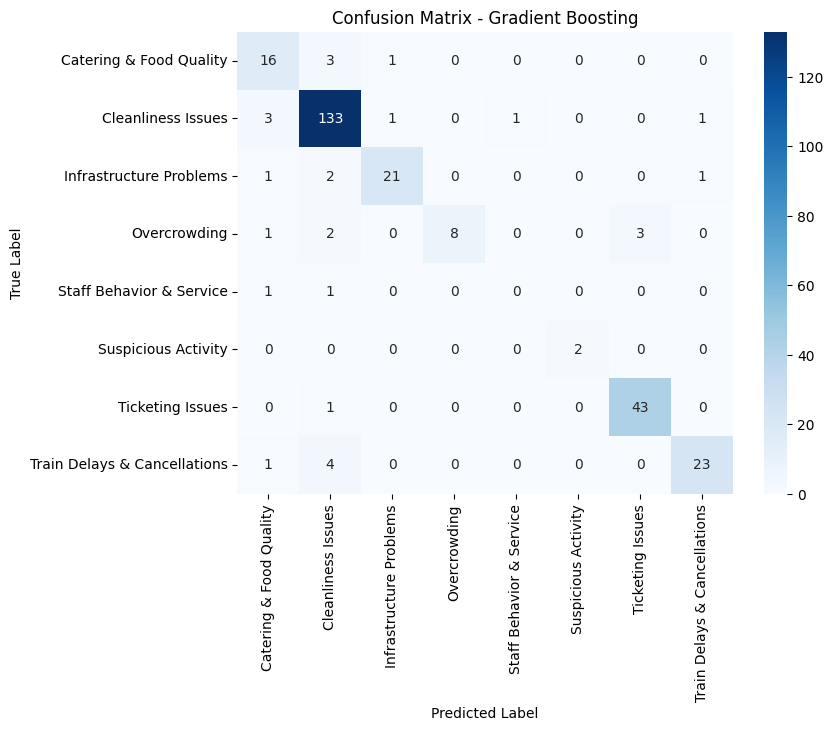

Training XGBoost...

XGBoost Results:
Accuracy: 0.8467
Precision: 0.8577
Recall: 0.8467
F1 Score: 0.8427


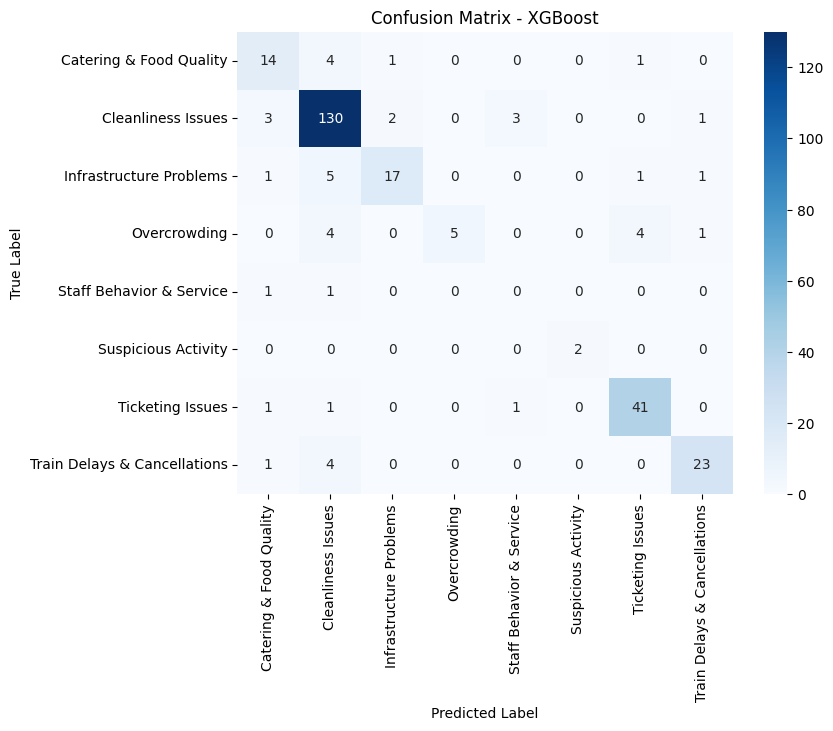


Overall Model Performance:
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.773723   0.802091  0.773723  0.739938
Naive Bayes          0.697080   0.708148  0.697080  0.635309
SVM                  0.777372   0.811608  0.777372  0.744111
KNN                  0.521898   0.425399  0.521898  0.371318
Random Forest        0.861314   0.856924  0.861314  0.850566
Gradient Boosting    0.897810   0.898733  0.897810  0.894234
XGBoost              0.846715   0.857703  0.846715  0.842709

Training BiLSTM Model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.4174 - loss: 1.8339 - val_accuracy: 0.5073 - val_loss: 1.5202
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4540 - loss: 1.5817 - val_accuracy: 0.6168 - val_loss: 1.2287
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.6208 - loss: 1.0883 - val_accuracy: 0.6642 - val_loss: 1.0858
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.7753 - loss: 0.6398 - val_accuracy: 0.6825 - val_loss: 1.0142
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.8565 - loss: 0.5284 - val_accuracy: 0.6861 - val_loss: 1.0797
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step

BiLSTM Accuracy: 0.6861

Training BERT Model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
69/69 [==============================] - 572s 8s/step - loss: 3.0714 - accuracy: 0.1658 - val_loss: 2.0271 - val_accuracy: 0.1022
Epoch 2/3
69/69 [==============================] - 528s 8s/step - loss: 2.1165 - accuracy: 0.0952 - val_loss: 2.0271 - val_accuracy: 0.1022
Epoch 3/3
9/9 [==============================] - 36s 4s/step

BERT Accuracy: 0.1022


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Deep Learning (BiLSTM, BERT)
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
import torch

# Load dataset
file_path = "/content/All_Complaints_Sorted.csv"
df = pd.read_csv(file_path)

# Text Preprocessing Function
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["Cleaned_Text"] = df["Cleaned_Text"].astype(str).apply(preprocess_text)

# Encode Category Labels
label_encoder = LabelEncoder()
df["Category_Encoded"] = label_encoder.fit_transform(df["Category"])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["Cleaned_Text"]).toarray()
y = df["Category_Encoded"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classification Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
}

# Training and Evaluation
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted")

    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = [acc, precision, recall, f1]

    # Print Metrics
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1 Score"]).T
print("\nOverall Model Performance:")
print(results_df)

# Save Results
results_df.to_csv("Classification_Results.csv", index=True)

### BiLSTM Model
print("\nTraining BiLSTM Model...")

# Tokenization for Deep Learning
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["Cleaned_Text"])
X_seq = tokenizer.texts_to_sequences(df["Cleaned_Text"])
X_pad = pad_sequences(X_seq, maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# BiLSTM Model
model = tf.keras.Sequential([
    Embedding(5000, 128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(16, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Predict and Evaluate BiLSTM
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"\nBiLSTM Accuracy: {acc:.4f}")
import numpy as np

# BERT Model
print("\nTraining BERT Model...")

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

# Tokenize for BERT
train_encodings = bert_tokenizer(list(df["Cleaned_Text"]), truncation=True, padding=True, max_length=100, return_tensors="tf")
# Convert TensorFlow tensor to NumPy array
X_data = np.array(train_encodings["input_ids"])

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)

bert_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
bert_model.fit(X_train, y_train, epochs=3, batch_size=16, validation_data=(X_test, y_test))

y_pred = np.argmax(bert_model.predict(X_test).logits, axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"\nBERT Accuracy: {acc:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
import nltk
import torch
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from transformers import pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
import tensorflow as tf

# Load dataset
df = pd.read_csv("All_Complaints_Sorted.csv")
df.dropna(subset=['Cleaned_Text', 'Department'], inplace=True)

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['Processed_Text'] = df['Cleaned_Text'].apply(preprocess_text)

# Encode department labels
departments = df['Department'].unique()
department_mapping = {dept: idx for idx, dept in enumerate(departments)}
df['Dept_Label'] = df['Department'].map(department_mapping)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['Processed_Text'], df['Dept_Label'], test_size=0.2, random_state=42)

# Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Gradient Boosting Model
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Model Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

# Save trained model and vectorizer
joblib.dump(model, 'best_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

# Load BERT Sentiment Analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Function to predict department and sentiment
def classify_complaint(complaint_text):
    processed_complaint = preprocess_text(complaint_text)
    transformed_complaint = vectorizer.transform([processed_complaint])

    # Predict department
    predicted_dept_label = model.predict(transformed_complaint)[0]
    predicted_dept = {v: k for k, v in department_mapping.items()}[predicted_dept_label]

    # Perform sentiment analysis
    sentiment_result = sentiment_pipeline(complaint_text)[0]
    sentiment_label = sentiment_result["label"]
    sentiment_score = sentiment_result["score"]

    return predicted_dept, sentiment_label, sentiment_score

# Save classified complaints to department-specific CSVs
def store_complaints():
    df['Predicted_Dept'], df['Sentiment'], df['Sentiment_Score'] = zip(*df['Processed_Text'].apply(classify_complaint))

    for dept in df['Predicted_Dept'].unique():
        df[df['Predicted_Dept'] == dept].to_csv(f'{dept}_complaints.csv', index=False)

store_complaints()

# User input function
def predict_department(complaint):
    department, sentiment, score = classify_complaint(complaint)
    print(f'Complaint assigned to: {department} | Sentiment: {sentiment} (Score: {score:.2f})')

# Example usage
new_complaint = input("Enter a complaint: ")
predict_department(new_complaint)


Model Accuracy: 0.8689, F1-score: 0.8650


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Enter a complaint: trains are 3 hrs late
Complaint assigned to: Operations & Scheduling | Sentiment: 3 stars (Score: 0.29)


In [ ]:
!pip install pandas scikit-learn transformers torch


In [ ]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.3
    Uninstalling transformers-4.50.3:
      Successfully uninstalled transformers-4.50.3


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("All_Complaints_Sorted.csv")

# Clean and filter data
df.dropna(subset=['SentimentText', 'Sentiment'], inplace=True)
df = df[df['Sentiment'].isin([1, 2, 3, 4, 5, 6, 7])]
df['Sentiment_Label'] = df['Sentiment'].astype(int) - 1  # 0 to 6

# Sentiment map (optional for displaying results)
sentiment_map = {
    0: "Very Negative",
    1: "Negative",
    2: "Slightly Negative",
    3: "Neutral",
    4: "Slightly Positive",
    5: "Positive",
    6: "Very Positive"
}

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['SentimentText'].tolist(),
    df['Sentiment_Label'].tolist(),
    test_size=0.2,
    stratify=df['Sentiment_Label'],
    random_state=42
)

# Tokenize using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    return encodings, labels

train_encodings, train_labels = tokenize(train_texts, train_labels)
val_encodings, val_labels = tokenize(val_texts, val_labels)

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Datasets and loaders
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)
model.to(device)

# Optimizer (torch.optim.Adam instead of AdamW)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation loop
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    print(classification_report(all_labels, all_preds, target_names=[sentiment_map[i] for i in range(7)]))

# Train and evaluate
for epoch in range(3):
    loss = train(model, train_loader, optimizer, loss_fn)
    print(f"Epoch {epoch+1} - Loss: {loss:.4f}")

evaluate(model, val_loader)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Loss: 1.5460
Epoch 2 - Loss: 0.7009
Epoch 3 - Loss: 0.3212
                   precision    recall  f1-score   support

    Very Negative       0.71      0.59      0.65        17
         Negative       0.80      0.67      0.73         6
Slightly Negative       0.91      0.94      0.92        31
          Neutral       0.88      0.86      0.87        44
Slightly Positive       0.86      0.95      0.90        60
         Positive       0.74      0.76      0.75        42
    Very Positive       0.87      0.72      0.79        18

         accuracy                           0.84       218
        macro avg       0.83      0.78      0.80       218
     weighted avg       0.84      0.84      0.84       218



In [ ]:

import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pd.read_csv("All_Complaints_Sorted.csv")

# Preprocess
def preprocess(text):
    text = text.lower()
    return re.sub(r"[^a-z0-9\s]", "", text)

df.dropna(subset=["Cleaned_Text", "Sentiment"], inplace=True)
df = df[df["Sentiment"].between(1, 7)]
df["Processed"] = df["Cleaned_Text"].apply(preprocess)
df["Sentiment"] = df["Sentiment"].astype(int) - 1

# Split
X_train, X_test, y_train, y_test = train_test_split(df["Processed"], df["Sentiment"], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Metrics
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Metrics:")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    # For binary metrics in multiclass, only general logic
    tn = np.sum(np.triu(cm, 1))
    fp = np.sum(np.tril(cm, -1))
    fn = fp
    tp = np.sum(np.diag(cm))

    specificity = tn / (tn + fp) if (tn + fp) else 0
    npv = tn / (tn + fn) if (tn + fn) else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"NPV: {npv:.4f}")
    print(f"Specificity: {specificity:.4f}")

# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
evaluate_model("Logistic Regression", y_test, lr.predict(X_test_tfidf))

# 2. Support Vector Machine
svm = SVC()
svm.fit(X_train_tfidf, y_train)
evaluate_model("SVM", y_test, svm.predict(X_test_tfidf))

# 3. K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)
evaluate_model("KNN", y_test, knn.predict(X_test_tfidf))

# 4. Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train_tfidf, y_train)
evaluate_model("Gradient Boosting", y_test, gb.predict(X_test_tfidf))

# 5. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_tfidf, y_train)
evaluate_model("XGBoost", y_test, xgb.predict(X_test_tfidf))

# 6. Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
evaluate_model("Random Forest", y_test, rf.predict(X_test_tfidf))

# 7. Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
evaluate_model("Naive Bayes", y_test, nb.predict(X_test_tfidf))

# 8. Softmax Classifier (Multiclass Logistic Regression using SGD)
softmax = SGDClassifier(loss="log_loss")
softmax.fit(X_train_tfidf, y_train)
evaluate_model("Softmax Classifier", y_test, softmax.predict(X_test_tfidf))

# 9. BiLSTM Model
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, validation_split=0.1, epochs=3, batch_size=32)

y_pred_bilstm = np.argmax(model.predict(X_test_pad), axis=1)
evaluate_model("BiLSTM", y_test, y_pred_bilstm)



Logistic Regression Metrics:
Accuracy: 0.8057
Precision: 0.8371
Recall: 0.8057
F1 Score: 0.7964
NPV: 0.6585
Specificity: 0.6585

SVM Metrics:
Accuracy: 0.7725
Precision: 0.8025
Recall: 0.7725
F1 Score: 0.7628
NPV: 0.6667
Specificity: 0.6667

KNN Metrics:
Accuracy: 0.6872
Precision: 0.6999
Recall: 0.6872
F1 Score: 0.6865
NPV: 0.5303
Specificity: 0.5303

Gradient Boosting Metrics:
Accuracy: 0.8152
Precision: 0.8422
Recall: 0.8152
F1 Score: 0.8179
NPV: 0.6410
Specificity: 0.6410


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:44:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Metrics:
Accuracy: 0.7725
Precision: 0.7900
Recall: 0.7725
F1 Score: 0.7752
NPV: 0.6042
Specificity: 0.6042

Random Forest Metrics:
Accuracy: 0.8294
Precision: 0.8561
Recall: 0.8294
F1 Score: 0.8306
NPV: 0.6389
Specificity: 0.6389

Naive Bayes Metrics:
Accuracy: 0.7014
Precision: 0.7375
Recall: 0.7014
F1 Score: 0.6781
NPV: 0.5079
Specificity: 0.5079

Softmax Classifier Metrics:
Accuracy: 0.8389
Precision: 0.8516
Recall: 0.8389
F1 Score: 0.8381
NPV: 0.6176
Specificity: 0.6176


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.2320 - loss: 1.8866 - val_accuracy: 0.3412 - val_loss: 1.7492
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.2864 - loss: 1.7515 - val_accuracy: 0.4471 - val_loss: 1.6428
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.4669 - loss: 1.4543 - val_accuracy: 0.5882 - val_loss: 1.2033
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step

BiLSTM Metrics:
Accuracy: 0.5545
Precision: 0.4729
Recall: 0.5545
F1 Score: 0.4956
NPV: 0.6383
Specificity: 0.6383


In [ ]:
def predict_sentiment(text, model, tokenizer):
    model.eval()
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    return sentiment_map[prediction]

# Loop for user input
while True:
    user_input = input("\nEnter a sentence to analyze sentiment (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    sentiment = predict_sentiment(user_input, model, tokenizer)
    print(f"Predicted Sentiment: {sentiment}")


Predicted Sentiment: Positive


In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

# Load dataset
df = pd.read_csv("All_Complaints_Sorted.csv")
df.dropna(subset=['Cleaned_Text', 'Department'], inplace=True)

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['Processed_Text'] = df['Cleaned_Text'].apply(preprocess_text)

# Encode department labels
departments = df['Department'].unique()
department_mapping = {dept: idx for idx, dept in enumerate(departments)}
df['Dept_Label'] = df['Department'].map(department_mapping)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['Processed_Text'], df['Dept_Label'], test_size=0.2, random_state=42)

# Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Gradient Boosting Model
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Model Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

# Save trained model and vectorizer
joblib.dump(model, 'best_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

# Function to predict department
def classify_complaint(complaint_text):
    processed_complaint = preprocess_text(complaint_text)
    transformed_complaint = vectorizer.transform([processed_complaint])
    predicted_dept_label = model.predict(transformed_complaint)[0]
    predicted_dept = {v: k for k, v in department_mapping.items()}[predicted_dept_label]
    return predicted_dept

# Save classified complaints to department-specific CSVs
def store_complaints():
    df['Predicted_Dept'] = df['Processed_Text'].apply(classify_complaint)
    for dept in df['Predicted_Dept'].unique():
        df[df['Predicted_Dept'] == dept].to_csv(f'{dept}_complaints.csv', index=False)

store_complaints()

# User input function
def predict_department(complaint):
    department = classify_complaint(complaint)
    print(f'Complaint assigned to: {department}')

# Example usage
new_complaint = input("Enter a complaint: ")
predict_department(new_complaint)


Model Accuracy: 0.8689, F1-score: 0.8650
Enter a complaint: suspicious bag in baggie
Complaint assigned to: Housekeeping Department


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("All_Complaints_Sorted.csv")

# Clean and filter data
df.dropna(subset=['SentimentText', 'Sentiment'], inplace=True)
df = df[df['Sentiment'].isin([1, 2, 3, 4, 5, 6, 7])]
df['Sentiment_Label'] = df['Sentiment'].astype(int) - 1  # 0 to 6

# Sentiment label names
sentiment_map = {
    0: "Very Negative",
    1: "Negative",
    2: "Slightly Negative",
    3: "Neutral",
    4: "Slightly Positive",
    5: "Positive",
    6: "Very Positive"
}

# Preprocessing
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['Processed_Text'] = df['SentimentText'].apply(preprocess)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    df['Processed_Text'],
    df['Sentiment_Label'],
    test_size=0.2,
    stratify=df['Sentiment_Label'],
    random_state=42
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train model
model = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = model.predict(X_val_tfidf)
print("Model Evaluation Report:\n")
print(classification_report(y_val, y_pred, target_names=[sentiment_map[i] for i in range(7)]))

# === Take input from user ===
user_input = input("\nEnter a complaint for sentiment prediction: ")
processed_input = preprocess(user_input)
input_vector = vectorizer.transform([processed_input])
predicted_label = model.predict(input_vector)[0]
predicted_sentiment = sentiment_map[predicted_label]

print(f"\nPredicted Sentiment: {predicted_sentiment}")


Model Evaluation Report:

                   precision    recall  f1-score   support

    Very Negative       0.89      0.47      0.62        17
         Negative       0.50      0.33      0.40         6
Slightly Negative       0.86      0.81      0.83        31
          Neutral       0.80      0.91      0.85        44
Slightly Positive       0.79      0.88      0.83        60
         Positive       0.69      0.64      0.67        42
    Very Positive       0.80      0.89      0.84        18

         accuracy                           0.78       218
        macro avg       0.76      0.70      0.72       218
     weighted avg       0.78      0.78      0.78       218


Enter a complaint for sentiment prediction: not feeling secure in baggie

Predicted Sentiment: Slightly Negative
